## Artificial neural networks with Keras

In a previous notebook, I showed [an example implementation of an artificial neural network (ANN)](http://jonchar.net/notebooks/Artificial-Neural-Network/) using only `numpy`. I took this approach because I really wanted to dig into the guts of how ANNs work to understand what they're doing on a fundamental level. The architecture of the example network I used was very simple: a single input layer for two features, two hidden layers with 5 hidden units each, and an output layer with two units corresponding to output classes. Each layer was fully-connected to the next one (these are known as "dense" layers), which showed how things can get complex fairly quickly. However, ANNs really shine in deep learning, where the number of layers far exceeds the number in my previous example. It's no surprise then that a number of libraries have recently popped up for working with ANNs in Python.

### Options for buliding ANNs in Python

Several libraries exist in the Python ecosystem for dealing with deep learning / ANNs in various capacities such as [Theano](http://deeplearning.net/software/theano/), [TensorFlow](https://www.tensorflow.org/), [Keras](http://keras.io/), [Lasagne](https://github.com/Lasagne/Lasagne), [NoLearn](https://github.com/dnouri/nolearn), and [Blocks](https://github.com/mila-udem/blocks). These libraries however are not all mutually exclusive nor do they serve to fill the same niches. You can choose your favorite based on how dirty you like to get your hands.

In this notebook I will re-implement our [example network](http://jonchar.net/notebooks/Artificial-Neural-Network/#An-example-network) using [Keras](http://keras.io/). Keras is a framework for building ANNs that sits on top of either a Theano or TensorFlow backend. I like the way Keras works because I find it allows you to focus on the network structure, and you can get a model up and training very quickly. The [Keras Blog](http://blog.keras.io/) has some great examples of how to use the framework.

### A note on using your GPU

It is common to use GPUs to accelerate the training of neural networks as the underlying computations lend themselves well to parallelization. If you want to use the GPU on your local machine for training neural networks, it may take some work to get things up and running. My current setup is a 2013 MacBook Pro running Arch Linux. The machine has a NVIDIA GeForce GT 650M and I've set up Theano to use the device. This requires installing CUDA and a compatible version of gcc as suggested by the [GPGPU page on the Arch Wiki](https://wiki.archlinux.org/index.php/GPGPU). I have tried to use Theano with a GPU on a Windows 8 machine, but had no success after investing a large amount of time. **TL;DR:** If you want to use your local GPU to train neural networks, you're probably best off running Linux.

### Setting up our network

Recall the structure of our example network from the previous notebook, where $s_l$ represents a layer of neurons in the network:

* $s_1 = 2$ (two input features, not counting one bias unit)
* $s_2 = 5$ (five hidden units, not counting one bias unit)
* $s_3 = 5$ (five hidden units, not counting one bias unit)
* $s_4 = 2$ (two output classes)

Also recall that we used a sigmoid activation function, and our cost function included a regularization term. We'll keep this in mind as we build our network.

The Keras API is based around layers that are organized into models (see [30 seconds to Keras](http://keras.io/#getting-started-30-seconds-to-keras) for a quick overview). Let's import the classes we will need.

In [1]:
import numpy as np
np.random.seed(0)
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Using Theano backend.
Using gpu device 0: GeForce GT 650M (CNMeM is disabled, cuDNN 5005)


Next, we'll generate the same dataset we used in our previous notebook.

((1000,), (1000, 2))

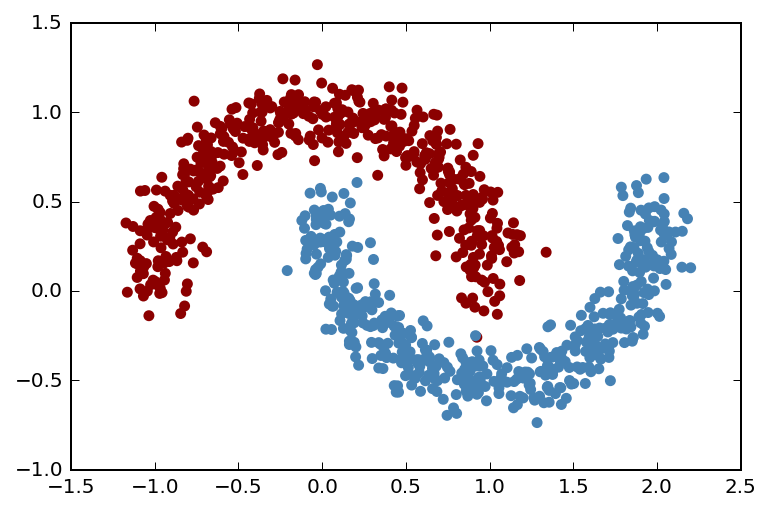

In [2]:
X, y = datasets.make_moons(n_samples=1000, noise=0.1, random_state=0)
colors = ['steelblue' if label == 1 else 'darkred' for label in y]
plt.scatter(X[:,0], X[:,1], color=colors)
y.shape, X.shape

### Defining the model

We first instantiate a model object, and then add layers to it with their respective activation functions and weight initializations. Keras has different activation functions built in such as `'sigmoid'`, `'tanh'`, `'softmax'`, and [many others](http://keras.io/activations/). Also built in are different weight [initialization options](http://keras.io/initializations/). The choice of activation and initialization can be specified using `kwargs` when adding a layer to the model. Our example network uses a sigmoid activation function and initializes the weights between $[-\epsilon, \epsilon]$. Where $\epsilon$ is defined as:

$$\epsilon = \frac{\sqrt{6}}{\sqrt{L_{output}+L_{input}}}$$

This initialization method corresponds to the `'glorot_uniform'` initialization option in Keras.

In [3]:
# Define our model object
model = Sequential()

# kwarg dict for convenience
layer_kw = dict(activation='sigmoid', init='glorot_uniform')

# Add layers to our model
model.add(Dense(output_dim=5, input_shape=(2, ), **layer_kw))
model.add(Dense(output_dim=5, **layer_kw))
model.add(Dense(output_dim=1, **layer_kw))

### Defining the optimizer

In Keras, you must also specify an optimizer to use when training your model. In our previous example we used batch gradient descent where we used our entire training set for each training iteration. Our data set wasn't particularly large so this was a feasible option, however in practice stochastic gradient descent is used. This is when the model is trained on smaller, random batches of the training set. This is also usually coupled with a smaller learning rate. Here we will define a stochastic gradient descent optimizer with a learning rate of 0.01 ($\alpha$, which we set to 0.5 in our previous example), which should behave similarly. In Keras, a stochastic gradient descent optimizer object is `SGD`.

In [4]:
sgd = SGD(lr=0.1)

### Putting it all together

Finally we must choose a loss function and "compile" our model. We will use a cross-entropy loss function corresponding to the loss in our previous example). In Keras-speak "compiling" essentially configures your model to work with your optimizer and loss function. You can specify the optimizer and loss function in kwargs using specific strings or by passing specific objects. We're using an optimizer with a custom learning rate with the vanilla cross-entropy loss function.

In [5]:
model.compile(optimizer=sgd, loss='binary_crossentropy')

### Training the model

We can now train our model using the `model.fit()` method. Usually this method prints a nice text-based indicator of the training progress. We'll turn this off (`verbose=0`) since we're going to use a large number of iterations (`nb_epoch=4000`, greater than our last example due to the smaller $\alpha$). We can also easily capture information about the training process in the `History` object returned by `model.fit()`. For good measure we'll also pass the `shuffle=True` so that our training data batches are shuffled before each pass.

In [6]:
history = model.fit(X[:500], y[:500], verbose=0, nb_epoch=4000, shuffle=True)

Once trained, we can have a look at our loss function over each epoch, as found in `history.history['loss']`. If all goes well, this should be monotonically decreasing, and close to zero.

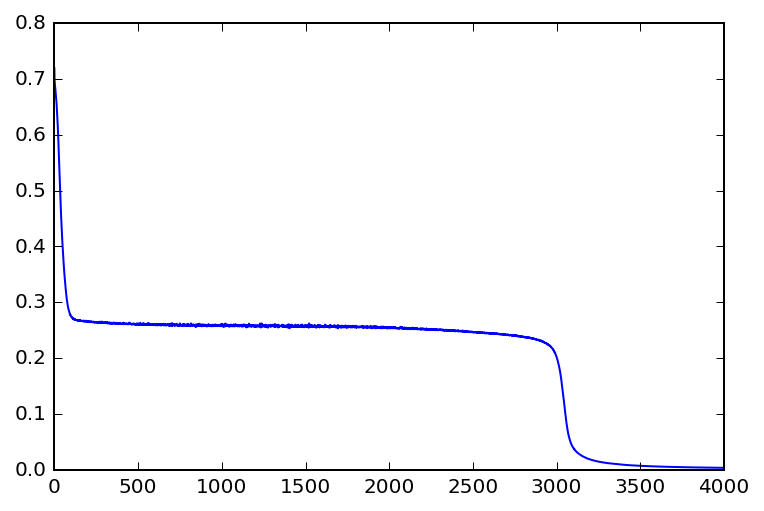

In [7]:
plt.plot(history.history['loss'])

Interesting...this looks a lot like the loss during traning of our [previous implementation](http://jonchar.net/notebooks/Artificial-Neural-Network/#Training-the-model:-Take-2).

### Visualizing the results

Here we'll bring back our `plot_decision_boundary` function and have it use a divergent color map.

In [8]:
def plot_decision_boundary(X, y, model, steps=1000, cmap='Paired'):
    """
    Function to plot the decision boundary and data points of a model.
    Data points are colored based on their actual label.
    """
    cmap = plt.get_cmap(cmap)
    
    # Define region of interest by data limits
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels = model.predict(X)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, lw=0)
    
    return fig, ax

(<matplotlib.figure.Figure at 0x7f313e9b6160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f31003d6d68>)

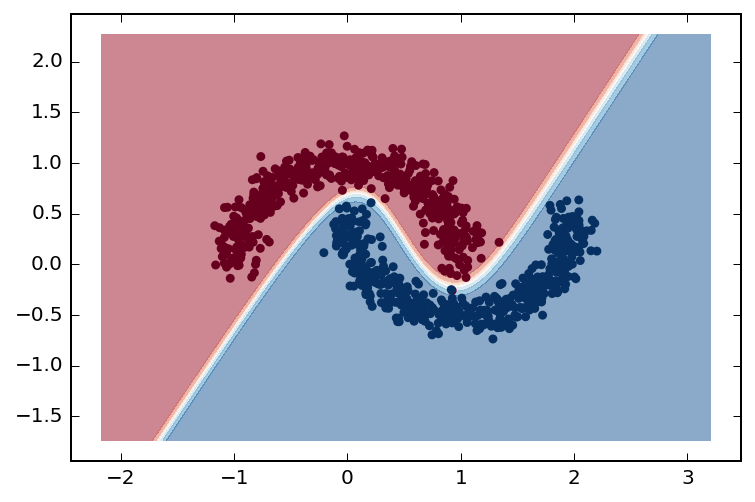

In [9]:
plot_decision_boundary(X, y, model, cmap='RdBu')

### In summary

We can see in this post that using a library dedicated to working with ANNs like Keras makes it much easier to get a model up and running. We recreated our example ANN using only 7 lines of Keras, and we could easily choose our activation function, weight initialization, optimizer, and loss function.

Check out the [Keras blog](http://blog.keras.io/) for some other examples of this library in action.

If you're feeling particularly ambitious and have your GPU set up to work with Keras, you can try [identifying nerve structures in ultrasound images on Kaggle](https://www.kaggle.com/c/ultrasound-nerve-segmentation) using [this convolutional ANN](https://github.com/jocicmarko/ultrasound-nerve-segmentation) put together by [Marko Jocić](https://twitter.com/_jocicmarko). Don't be intimidated, it's not as hard to run as it sounds!